# Tensorflow : classifying cars and predicting their price

##### Importing libraries

In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, confusion_matrix
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

##### Importing the data

In [4]:
data = pd.read_csv('C:/Users/Nicolas/Documents/Scraping/thecarconnection/full_dataset.csv', 
                 index_col=0).sample(frac=1, random_state=42).reset_index(drop=True)
dataset = data.copy()

Taking a peek at the data

In [6]:
data.drop(['Style Name', 'Body Style'], axis=1).head()

,MSRP,Make,Model,Drivetrain,Passenger Capacity,Passenger Doors,EPA Classification,Front Shoulder Room (in),Front Head Room (in),Second Leg Room (in),...,Rear Wheel Size,Front Wheel Size,Tire Rating,Tire Width Ratio,Wheel Size Ratio,Tire Ratio,Year,Country,Country Code,Category
0,30034.0,GMC,Sierra 2500HD,Four Wheel Drive,6.0,2.0,None,65.2,41.0,33.7,...,16.0,16.0,R,1.0,1.0,7.0,2002.0,USA,6.0,Pickup
1,19515.0,Ford,Ranger,Rear Wheel Drive,5.0,2.0,None,54.5,39.2,39.1,...,15.0,15.0,R,1.0,1.0,7.0,2010.0,USA,6.0,Pickup
2,24595.0,Subaru,Outback,All Wheel Drive,5.0,4.0,Midsize Station Wagon,56.3,40.8,37.8,...,17.0,17.0,R,1.0,1.0,6.0,2010.0,Japan,2.0,Car
3,56600.0,Porsche,Cayenne,All Wheel Drive,5.0,4.0,None,58.9,39.6,36.0,...,18.0,18.0,V,1.0,1.0,5.0,2014.0,Germany,0.0,SUV
4,21795.0,Mazda,CX-5,Front Wheel Drive,5.0,4.0,Small SUV 2WD,57.5,40.1,39.3,...,17.0,17.0,H,1.0,1.0,6.0,2016.0,Japan,2.0,SUV


In [9]:
data.shape

(31237, 81)

31,237 rows and 81 columns


## Preprocessing

##### Making sure the data is balanced

In [10]:
data['EPA Classification'].value_counts().head(8)

None             10555
Compact           4089
Midsize           3585
SUV 4WD           2150
Subcompact        1762
Large             1626
SUV 2WD           1285
Small SUV 4WD     1258
Name: EPA Classification, dtype: int64

In [11]:
suv_awd = data.loc[data['EPA Classification'] == 'SUV 4WD'].sample(n=2000)
midsized_car = data.loc[data['EPA Classification'] == 'Midsize'].sample(n=2000)
compact_car = data.loc[data['EPA Classification'] == 'Compact'].sample(n=2000)

In [12]:
df = pd.concat([suv_awd, compact_car, midsized_car], axis=0, sort=False).sample(frac=1)

##### Double checking the balanced data

In [13]:
df['EPA Classification'].value_counts().head()

Midsize    2000
SUV 4WD    2000
Compact    2000
Name: EPA Classification, dtype: int64

Text(0.5, 1.0, 'Pie Chart of Car Types')

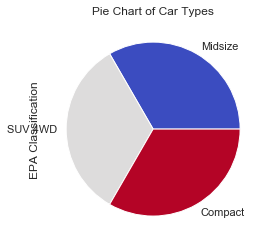

In [14]:
df['EPA Classification'].value_counts().head().plot(kind='pie', cmap='coolwarm')
plt.title('Pie Chart of Car Types')

##### Separating the `x` and `y`

In [16]:
x = df.loc[:, ['Drivetrain', 'Passenger Capacity', 'Passenger Doors', 'Body Style',
       'EPA Classification', 'Front Shoulder Room (in)',
       'Front Head Room (in)', 'Second Leg Room (in)', 'Front Leg Room (in)',
       'Second Shoulder Room (in)', 'Second Head Room (in)',
       'Height, Overall (in)', 'Wheelbase (in)', 'Width, Max w/o mirrors (in)',
       'Fuel Tank Capacity, Approx (gal)', 'EPA Fuel Economy Est - Hwy (MPG)',
       'EPA Fuel Economy Est - City (MPG)', 'Fuel System',
       'Third Gear Ratio (:1)', 'First Gear Ratio (:1)',
       'Fourth Gear Ratio (:1)', 'Second Gear Ratio (:1)',
       'Front Brake Rotor Diam x Thickness (in)',
       'Rear Brake Rotor Diam x Thickness (in)', 'Steering Type',
       'Turning Diameter - Curb to Curb', 'Rear Wheel Material',
       'Suspension Type - Front', 'Air Bag-Frontal-Driver',
       'Air Bag-Frontal-Passenger', 'Air Bag-Passenger Switch (On/Off)',
       'Air Bag-Side Body-Front', 'Air Bag-Side Body-Rear',
       'Air Bag-Side Head-Front', 'Air Bag-Side Head-Rear', 'Brakes-ABS',
       'Child Safety Rear Door Locks', 'Daytime Running Lights',
       'Traction Control', 'Night Vision', 'Rollover Protection Bars',
       'Fog Lamps', 'Parking Aid', 'Tire Pressure Monitor', 'Back-Up Camera',
       'Stability Control', 'Other Features', 'Basic Miles/km', 'Basic Years',
       'Corrosion Miles/km', 'Corrosion Years', 'Drivetrain Miles/km',
       'Drivetrain Years', 'Roadside Assistance Miles/km',
       'Roadside Assistance Years', 'Hybrid Engine', 'Gears', 'Net Horsepower',
       'Net Horsepower RPM', 'Net Torque', 'Net Torque RPM', 'Cylinders',
       'Engine Configuration', 'Displacement (L)', 'Displacement (cc)',
       'Rear Tire Width', 'Front Tire Width', 'Rear Wheel Size',
       'Front Wheel Size', 'Tire Rating', 'Tire Width Ratio',
       'Wheel Size Ratio', 'Tire Ratio', 'Year', 'Country',
       'Category']]

Putting the target in neural network friendly format

In [19]:
y = OrdinalEncoder().fit_transform(np.array(df['EPA Classification']).reshape(-1, 1))
y = keras.utils.to_categorical(y, 3)

In [20]:
y[:10]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

##### One hot encoding certain variables

In [21]:
specs_to_dummies = ['Drivetrain', 'Fuel System', 'Steering Type', 'Rear Wheel Material',
                   'Suspension Type - Front', 'Engine Configuration', 'Tire Rating', 'Country',
                   'Category']

for item in specs_to_dummies:
    dummies = pd.get_dummies(x[item], prefix_sep=': ', prefix=item)
    x = x.drop(item, axis=1)
    x = pd.concat([x, dummies], sort=False, axis=1)
x = x.reset_index(drop=True)

specs_to_one_two = ['Air Bag-Frontal-Driver', 'Air Bag-Frontal-Passenger', 'Air Bag-Passenger Switch (On/Off)',
       'Air Bag-Side Body-Front', 'Air Bag-Side Body-Rear', 'Air Bag-Side Head-Front', 'Air Bag-Side Head-Rear', 
       'Brakes-ABS', 'Child Safety Rear Door Locks', 'Daytime Running Lights',
       'Traction Control', 'Night Vision', 'Rollover Protection Bars',
       'Fog Lamps', 'Parking Aid', 'Tire Pressure Monitor', 'Back-Up Camera',
       'Stability Control']

for item in specs_to_one_two:
    dummies = pd.get_dummies(x[item], prefix_sep=': ', prefix=item, drop_first=True)
    x = x.drop(item, axis=1)
    x = pd.concat([x, dummies], sort=False, axis=1)
x = x.reset_index(drop=True)

x.drop(['Body Style', 'EPA Classification', 'Other Features'], axis=1, inplace=True)

Checking what it looks like now...

In [22]:
x.head()

,Passenger Capacity,Passenger Doors,Front Shoulder Room (in),Front Head Room (in),Second Leg Room (in),Front Leg Room (in),Second Shoulder Room (in),Second Head Room (in),"Height, Overall (in)",Wheelbase (in),...,Child Safety Rear Door Locks: Yes,Daytime Running Lights: Yes,Traction Control: Yes,Night Vision: Yes,Rollover Protection Bars: Yes,Fog Lamps: Yes,Parking Aid: Yes,Tire Pressure Monitor: Yes,Back-Up Camera: Yes,Stability Control: Yes
0,7.0,4.0,58.6,40.1,41.8,41.3,58.1,39.0,67.4,117.9,...,1,0,1,0,0,1,1,1,1,1
1,5.0,4.0,58.9,39.7,36.1,42.6,58.4,39.5,71.3,106.7,...,1,0,0,0,0,0,0,0,0,0
2,5.0,4.0,56.2,40.3,35.7,42.2,55.3,37.3,56.5,106.3,...,1,1,1,0,0,0,0,1,1,1
3,7.0,4.0,61.5,41.4,39.5,42.9,61.0,40.6,70.0,112.8,...,1,1,1,0,0,1,0,1,1,1
4,5.0,4.0,57.3,37.7,36.0,41.5,57.2,37.0,58.3,113.7,...,0,1,1,0,0,1,0,1,0,1


In [23]:
x = x.astype('float64')

Transforming the data into numbers between 0 and 1

In [24]:
mm_scaler = MinMaxScaler(feature_range=(0, 1))
x = mm_scaler.fit_transform(x)

## Building and training the model

##### Building

In [25]:
model = Sequential()
model.add(Dense(8, input_shape=(x.shape[1],)))
model.add(Dense(100, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(3, activation='softmax'))

##### Compiling

In [26]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

##### Training

In [27]:
history = model.fit(x, y, 
                    epochs=100, 
                    batch_size=8, 
                    validation_split=0.1, 
                    verbose=0)

## Final score and summary

In [28]:
print('highest validation accuracy: {}'.format(max(history.history['val_accuracy']))) 
print('lowest validation loss: {}'.format(min(history.history['val_loss'])))
print('highest accuracy: {}'.format(max(history.history['accuracy']))) 
print('lowest loss: {}'.format(min(history.history['loss'])))

highest validation accuracy: 0.9900000095367432
lowest validation loss: 0.02737244809407835
highest accuracy: 0.9962962865829468
lowest loss: 0.008325046490525604


Highest accuracy in the validation sample: 99.00%, loss of 2.73%

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1648      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               900       
_________________________________________________________________
dense_2 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 603       
Total params: 23,351
Trainable params: 23,351
Non-trainable params: 0
_________________________________________________________________


##### Tracking the loss and metrics

In [31]:
history_data = pd.DataFrame(history.history)
history_data.index += 1
history_data.head()

,loss,accuracy,val_loss,val_accuracy
1,0.410511,0.793704,0.272235,0.883333
2,0.199583,0.916296,0.208159,0.918333
3,0.156329,0.942407,0.148261,0.936667
4,0.130653,0.950741,0.141427,0.938333
5,0.117328,0.956481,0.135560,0.943333


In [32]:
start = 0
stop = history_data.shape[0]

Text(0, 0.5, 'Loss')

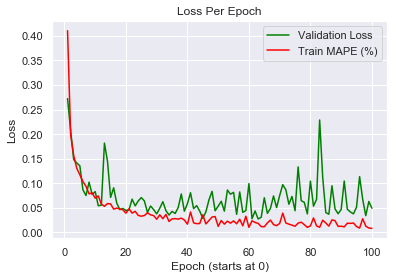

In [34]:
plt.plot(1+np.arange(start, stop), history_data['val_loss'][start:], c='green')
plt.plot(1+np.arange(start, stop), history_data['loss'][start:], c='red')
plt.legend(('Validation Loss', 'Train MAPE (%)'))
plt.title('Loss Per Epoch')
plt.xlabel('Epoch (starts at {})'.format(start))
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

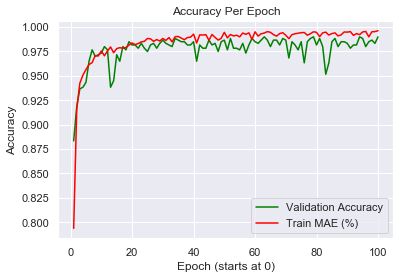

In [35]:
plt.plot(1+np.arange(start, stop), history_data['val_accuracy'][start:], c='green')
plt.plot(1+np.arange(start, stop), history_data['accuracy'][start:], c='red')
plt.legend(('Validation Accuracy', 'Train MAE (%)'))
plt.title('Accuracy Per Epoch')
plt.xlabel('Epoch (starts at {})'.format(start))
plt.ylabel('Accuracy')

## Let's predict a continuous variable (fuel economy, highway)

##### Removing 'not applicable' cars

In [37]:
data_no_electric = data.loc[data['Make'] != 'Tesla']
data_no_electric = data.loc[data['Hybrid Engine'] != 1]
data_no_electric = data.loc[data['Engine Configuration'] != 'C']
data_no_electric = data_no_electric.loc[data_no_electric['Model'] != 'i3']
data_no_electric = data_no_electric.loc[data_no_electric['Model'] != 'Mirai']

Selecting variables

In [38]:
x_2 = data_no_electric.loc[:, ['Drivetrain', 'Passenger Capacity', 'Passenger Doors', 
       'Body Style', 'Front Shoulder Room (in)',
       'Front Head Room (in)', 'Second Leg Room (in)', 'Front Leg Room (in)',
       'Second Shoulder Room (in)', 'Second Head Room (in)',
       'Height, Overall (in)', 'Wheelbase (in)', 'Width, Max w/o mirrors (in)',
       'Fuel Tank Capacity, Approx (gal)', 'Fuel System',
       'Third Gear Ratio (:1)', 'First Gear Ratio (:1)',
       'Fourth Gear Ratio (:1)', 'Second Gear Ratio (:1)',
       'Front Brake Rotor Diam x Thickness (in)',
       'Rear Brake Rotor Diam x Thickness (in)', 'Steering Type',
       'Turning Diameter - Curb to Curb', 'Rear Wheel Material',
       'Suspension Type - Front', 'Air Bag-Frontal-Driver',
       'Air Bag-Frontal-Passenger', 'Air Bag-Passenger Switch (On/Off)',
       'Air Bag-Side Body-Front', 'Air Bag-Side Body-Rear',
       'Air Bag-Side Head-Front', 'Air Bag-Side Head-Rear', 'Brakes-ABS',
       'Child Safety Rear Door Locks', 'Daytime Running Lights',
       'Traction Control', 'Night Vision', 'Rollover Protection Bars',
       'Fog Lamps', 'Parking Aid', 'Tire Pressure Monitor', 'Back-Up Camera',
       'Stability Control', 'Basic Miles/km', 'Basic Years',
       'Corrosion Miles/km', 'Corrosion Years', 'Drivetrain Miles/km',
       'Drivetrain Years', 'Roadside Assistance Miles/km',
       'Roadside Assistance Years', 'Hybrid Engine', 'Gears', 'Net Horsepower',
       'Net Horsepower RPM', 'Net Torque', 'Net Torque RPM', 'Cylinders',
       'Engine Configuration', 'Displacement (L)', 'Displacement (cc)',
       'Rear Tire Width', 'Front Tire Width', 'Rear Wheel Size',
       'Front Wheel Size', 'Tire Rating', 'Tire Width Ratio',
       'Wheel Size Ratio', 'Tire Ratio', 'Year', 'Country',
       'Category']]
y_2 = np.array(data_no_electric.loc[:, 'EPA Fuel Economy Est - City (MPG)'])

##### One hot encoding

In [39]:
specs_to_dummies = ['Body Style', 'Drivetrain', 'Fuel System', 'Steering Type', 'Rear Wheel Material',
                   'Suspension Type - Front', 'Engine Configuration', 'Tire Rating', 'Country',
                   'Category']

for item in specs_to_dummies:
    dummies = pd.get_dummies(x_2[item], prefix_sep=': ', prefix=item)
    x_2 = x_2.drop(item, axis=1)
    x_2 = pd.concat([x_2, dummies], sort=False, axis=1)
x_2 = x_2.reset_index(drop=True)

In [40]:
specs_to_one_two = ['Air Bag-Frontal-Driver', 'Air Bag-Frontal-Passenger', 'Air Bag-Passenger Switch (On/Off)',
       'Air Bag-Side Body-Front', 'Air Bag-Side Body-Rear', 'Air Bag-Side Head-Front', 'Air Bag-Side Head-Rear', 
       'Brakes-ABS', 'Child Safety Rear Door Locks', 'Daytime Running Lights',
       'Traction Control', 'Night Vision', 'Rollover Protection Bars',
       'Fog Lamps', 'Parking Aid', 'Tire Pressure Monitor', 'Back-Up Camera',
       'Stability Control']

In [41]:
for item in specs_to_one_two:
    dummies = pd.get_dummies(x_2[item], prefix_sep=': ', prefix=item, drop_first=True)
    x_2 = x_2.drop(item, axis=1)
    x_2 = pd.concat([x_2, dummies], sort=False, axis=1)
x_2 = x_2.reset_index(drop=True)

##### Transforming the data into numbers between 0 and 1

In [42]:
x_2 = x_2.astype('float64')
x_2 = mm_scaler.fit_transform(x_2)

##### Train test split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(x_2, y_2, test_size=0.2)

## Bulding and training the model

##### Building

In [55]:
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],)))
model.add(Dense(100, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(1, activation='linear'))

##### Compiling

In [56]:
model.compile(optimizer='adam',
              loss='mean_absolute_percentage_error',
              metrics=['mae'])

##### Training

In [57]:
epochs = 1_00
batch_size = 16
validation_split = 0.1

In [58]:
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_split=validation_split, 
                    verbose=0)

##### Best model

In [59]:
print('lowest validation mae: {}'.format(min(history.history['val_mae']))) 
print('lowest validation mape: {}'.format(min(history.history['val_loss']))) 

lowest validation mae: 0.5974475145339966
lowest validation mape: 2.9362442361726293


In [60]:
history_data = pd.DataFrame(history.history)
history_data.index += 1
history_data.head()

,loss,mae,val_loss,val_mae
1,9.202828,1.915905,6.498142,1.310491
2,6.004429,1.235901,5.318348,1.108389
3,5.461716,1.116605,5.697490,1.170793
4,5.199555,1.063009,5.626722,1.137095
5,4.907773,1.003848,4.639775,0.955369


In [61]:
start = 0
stop = history_data.shape[0]

Text(0, 0.5, 'MAPE (%)')

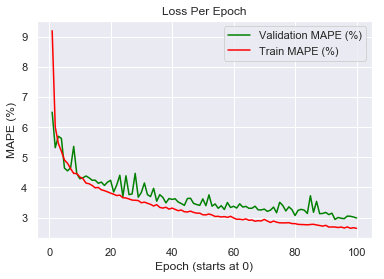

In [63]:
plt.plot(1+np.arange(start, stop), history_data['val_loss'][start:], c='green')
plt.plot(1+np.arange(start, stop), history_data['loss'][start:], c='red')
plt.legend(('Validation MAPE (%)', 'Train MAPE (%)'))
plt.title('Loss Per Epoch')
plt.xlabel('Epoch (starts at {})'.format(start))
plt.ylabel('MAPE (%)')

Text(0, 0.5, 'MAE')

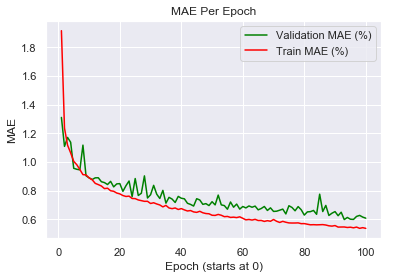

In [64]:
plt.plot(1+np.arange(start, stop), history_data['val_mae'][start:], c='green')
plt.plot(1+np.arange(start, stop), history_data['mae'][start:], c='red')
plt.legend(('Validation MAE (%)', 'Train MAE (%)'))
plt.title('MAE Per Epoch')
plt.xlabel('Epoch (starts at {})'.format(start))
plt.ylabel('MAE')

##### Plotting the predicted values

Text(0.5, 1.0, 'Predicted vs Actual Fuel Economy - City (MPG)')

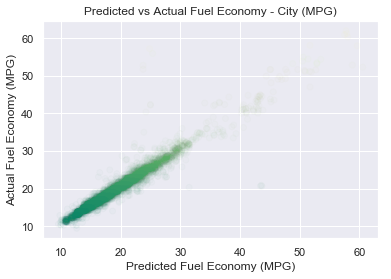

In [68]:
plt.scatter(model.predict(X_test), y_test + np.random.rand(len(X_test)), alpha=0.02, 
           c=y_test, cmap='summer')  
plt.xlabel('Predicted Fuel Economy (MPG)')
plt.ylabel('Actual Fuel Economy (MPG)')
plt.title('Predicted vs Actual Fuel Economy - City (MPG)')

In [69]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                18368     
_________________________________________________________________
dense_16 (Dense)             (None, 100)               6500      
_________________________________________________________________
dense_17 (Dense)             (None, 200)               20200     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 201       
Total params: 45,269
Trainable params: 45,269
Non-trainable params: 0
_________________________________________________________________


# Predicting Type of Car

In [72]:
data['Category'].value_counts()

Car       14085
SUV        8084
Pickup     8022
Van        1046
Name: Category, dtype: int64

In [73]:
car = data.loc[data['Category'] == 'Car'].sample(n=8_000)
suv = data.loc[data['Category'] == 'SUV'].sample(n=8_000)
pickup = data.loc[data['Category'] == 'Pickup'].sample(n=8_000)

In [74]:
df = pd.concat([car, suv, pickup], axis=0, sort=False).sample(frac=1).reset_index(drop=True)

In [76]:
df.drop(['Body Style', 'Style Name', 'Drivetrain', 'EPA Classification'], axis=1).head()

,MSRP,Make,Model,Passenger Capacity,Passenger Doors,Front Shoulder Room (in),Front Head Room (in),Second Leg Room (in),Front Leg Room (in),Second Shoulder Room (in),...,Rear Wheel Size,Front Wheel Size,Tire Rating,Tire Width Ratio,Wheel Size Ratio,Tire Ratio,Year,Country,Country Code,Category
0,35795.0,Dodge,Durango,7.0,4.0,58.50,39.9,38.60,40.3,58.30,...,18.0,18.0,R,1.000000,1.0,5.0,2012.0,USA,6.0,SUV
1,31495.0,Subaru,Legacy,5.0,4.0,54.40,38.7,33.90,44.1,53.70,...,17.0,17.0,V,1.000000,1.0,5.0,2008.0,Japan,2.0,Car
2,32395.0,Ram,2500,3.0,2.0,66.00,40.3,40.43,41.0,65.69,...,17.0,17.0,R,1.000000,1.0,7.0,2013.0,USA,6.0,Pickup
3,33645.0,Chevrolet,Silverado 1500,6.0,4.0,65.93,42.8,34.63,45.0,65.80,...,17.0,17.0,R,1.000000,1.0,5.0,2017.0,USA,6.0,Pickup
4,81800.0,Porsche,911,4.0,2.0,51.70,38.0,29.80,41.6,47.42,...,18.0,18.0,Z,1.311111,1.0,4.0,2003.0,Germany,0.0,Car


Choosing variables

In [77]:
X = df.loc[:, ['Drivetrain', 'Passenger Capacity', 'Passenger Doors', 'Body Style',
       'EPA Classification', 'Front Shoulder Room (in)',
       'Front Head Room (in)', 'Second Leg Room (in)', 'Front Leg Room (in)',
       'Second Shoulder Room (in)', 'Second Head Room (in)',
       'Height, Overall (in)', 'Wheelbase (in)', 'Width, Max w/o mirrors (in)',
       'Fuel Tank Capacity, Approx (gal)', 'EPA Fuel Economy Est - Hwy (MPG)',
       'EPA Fuel Economy Est - City (MPG)', 'Fuel System',
       'Third Gear Ratio (:1)', 'First Gear Ratio (:1)',
       'Fourth Gear Ratio (:1)', 'Second Gear Ratio (:1)',
       'Front Brake Rotor Diam x Thickness (in)',
       'Rear Brake Rotor Diam x Thickness (in)', 'Steering Type',
       'Turning Diameter - Curb to Curb', 'Rear Wheel Material',
       'Suspension Type - Front', 'Air Bag-Frontal-Driver',
       'Air Bag-Frontal-Passenger', 'Air Bag-Passenger Switch (On/Off)',
       'Air Bag-Side Body-Front', 'Air Bag-Side Body-Rear',
       'Air Bag-Side Head-Front', 'Air Bag-Side Head-Rear', 'Brakes-ABS',
       'Child Safety Rear Door Locks', 'Daytime Running Lights',
       'Traction Control', 'Night Vision', 'Rollover Protection Bars',
       'Fog Lamps', 'Parking Aid', 'Tire Pressure Monitor', 'Back-Up Camera',
       'Stability Control', 'Other Features', 'Basic Miles/km', 'Basic Years',
       'Corrosion Miles/km', 'Corrosion Years', 'Drivetrain Miles/km',
       'Drivetrain Years', 'Roadside Assistance Miles/km',
       'Roadside Assistance Years', 'Hybrid Engine', 'Gears', 'Net Horsepower',
       'Net Horsepower RPM', 'Net Torque', 'Net Torque RPM', 'Cylinders',
       'Engine Configuration', 'Displacement (L)', 'Displacement (cc)',
       'Rear Tire Width', 'Front Tire Width', 'Rear Wheel Size',
       'Front Wheel Size', 'Tire Rating', 'Tire Width Ratio',
       'Wheel Size Ratio', 'Tire Ratio', 'Year', 'Country']]
y = df['Category']

Making the target a neural network friendly format

In [78]:
y = OrdinalEncoder().fit_transform(np.array(y).reshape(-1, 1))
y = keras.utils.to_categorical(y, 3)

In [79]:
y[:10]

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

##### One hot encoding

In [80]:
specs_to_dummies = ['Drivetrain', 'Fuel System', 'Steering Type', 'Rear Wheel Material',
                   'Suspension Type - Front', 'Engine Configuration', 'Tire Rating', 'Country']

In [81]:
for item in specs_to_dummies:
    dummies = pd.get_dummies(X[item], prefix_sep=': ', prefix=item)
    X = X.drop(item, axis=1)
    X = pd.concat([X, dummies], sort=False, axis=1)
X = X.reset_index(drop=True)

In [82]:
specs_to_one_two = ['Air Bag-Frontal-Driver', 'Air Bag-Frontal-Passenger', 'Air Bag-Passenger Switch (On/Off)',
       'Air Bag-Side Body-Front', 'Air Bag-Side Body-Rear', 'Air Bag-Side Head-Front', 'Air Bag-Side Head-Rear', 
       'Brakes-ABS', 'Child Safety Rear Door Locks', 'Daytime Running Lights',
       'Traction Control', 'Night Vision', 'Rollover Protection Bars',
       'Fog Lamps', 'Parking Aid', 'Tire Pressure Monitor', 'Back-Up Camera',
       'Stability Control']

In [83]:
for item in specs_to_one_two:
    dummies = pd.get_dummies(X[item], prefix_sep=': ', prefix=item, drop_first=True)
    X = X.drop(item, axis=1)
    X = pd.concat([X, dummies], sort=False, axis=1)
X = X.reset_index(drop=True)

Dropping target-like variables

In [84]:
X.drop(['Body Style', 'EPA Classification', 'Other Features'], axis=1, inplace=True)

Scaling the predictors for the neural net

In [85]:
X = X.astype('float64')

In [86]:
mm_scaler = MinMaxScaler(feature_range=(0, 1))
X = mm_scaler.fit_transform(X)

##### Building the model

In [87]:
model = Sequential()
model.add(Dense(64, input_shape=(X.shape[1],)))
model.add(Dense(100, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(3, activation='softmax'))

##### Compiling the model

In [90]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

##### Model parameters

In [93]:
epochs = 1_00
batch_size = 32
validation_split = 0.1

##### Training the model

In [94]:
history = model.fit(X, y, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_split=validation_split, 
                    verbose=0)

In [95]:
print('highest validation accuracy: {}'.format(max(history.history['val_accuracy']))) 
print('lowest validation loss: {}'.format(min(history.history['val_loss'])))

highest accuracy: 0.9991666674613953
lowest loss: 0.001651650071304592


In [96]:
history_cat = pd.DataFrame(history.history)
history_cat.index += 1
history_cat.head()

,loss,accuracy,val_loss,val_accuracy
1,0.023580,0.991574,0.018765,0.994583
2,0.022685,0.991898,0.016947,0.994583
3,0.017729,0.993796,0.034263,0.987500
4,0.021513,0.992639,0.038565,0.989583
5,0.015843,0.994352,0.033469,0.988333


In [97]:
start = 0
stop = history_cat.shape[0]

Text(0, 0.5, 'Accuracy (%)')

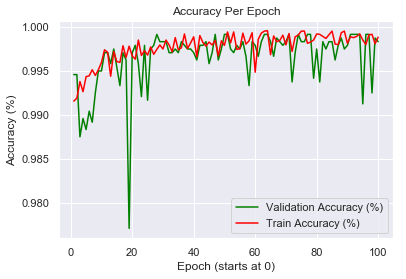

In [98]:
plt.plot(1+np.arange(start, stop), history_cat['val_accuracy'][start:], c='green')
plt.plot(1+np.arange(start, stop), history_cat['accuracy'][start:], c='red')
plt.legend(('Validation Accuracy (%)', 'Train Accuracy (%)'))
plt.title('Accuracy Per Epoch')
plt.xlabel('Epoch (starts at {})'.format(start))
plt.ylabel('Accuracy (%)')

Text(0, 0.5, 'Loss')

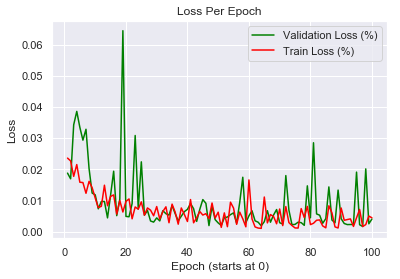

In [99]:
plt.plot(1+np.arange(start, stop), history_cat['val_loss'][start:], 'green')
plt.plot(1+np.arange(start, stop), history_cat['loss'][start:], c='red')
plt.legend(('Validation Loss (%)', 'Train Loss (%)'))
plt.title('Loss Per Epoch')
plt.xlabel('Epoch (starts at {})'.format(start))
plt.ylabel('Loss')

# Predicting `MSRP`

#### Picking the features

In [100]:
x = dataset.loc[:, ['Drivetrain', 'Passenger Capacity', 'Passenger Doors', 'Body Style',
       'EPA Classification', 'Front Shoulder Room (in)',
       'Front Head Room (in)', 'Second Leg Room (in)', 'Front Leg Room (in)',
       'Second Shoulder Room (in)', 'Second Head Room (in)',
       'Height, Overall (in)', 'Wheelbase (in)', 'Width, Max w/o mirrors (in)',
       'Fuel Tank Capacity, Approx (gal)', 'EPA Fuel Economy Est - Hwy (MPG)',
       'EPA Fuel Economy Est - City (MPG)', 'Fuel System',
       'Third Gear Ratio (:1)', 'First Gear Ratio (:1)',
       'Fourth Gear Ratio (:1)', 'Second Gear Ratio (:1)',
       'Front Brake Rotor Diam x Thickness (in)',
       'Rear Brake Rotor Diam x Thickness (in)', 'Steering Type',
       'Turning Diameter - Curb to Curb', 'Rear Wheel Material',
       'Suspension Type - Front', 'Air Bag-Frontal-Driver',
       'Air Bag-Frontal-Passenger', 'Air Bag-Passenger Switch (On/Off)',
       'Air Bag-Side Body-Front', 'Air Bag-Side Body-Rear',
       'Air Bag-Side Head-Front', 'Air Bag-Side Head-Rear', 'Brakes-ABS',
       'Child Safety Rear Door Locks', 'Daytime Running Lights',
       'Traction Control', 'Night Vision', 'Rollover Protection Bars',
       'Fog Lamps', 'Parking Aid', 'Tire Pressure Monitor', 'Back-Up Camera',
       'Stability Control', 'Other Features', 'Basic Miles/km', 'Basic Years',
       'Corrosion Miles/km', 'Corrosion Years', 'Drivetrain Miles/km',
       'Drivetrain Years', 'Roadside Assistance Miles/km',
       'Roadside Assistance Years', 'Hybrid Engine', 'Gears', 'Net Horsepower',
       'Net Horsepower RPM', 'Net Torque', 'Net Torque RPM', 'Cylinders',
       'Engine Configuration', 'Displacement (L)', 'Displacement (cc)',
       'Rear Tire Width', 'Front Tire Width', 'Rear Wheel Size',
       'Front Wheel Size', 'Tire Rating', 'Tire Width Ratio',
       'Wheel Size Ratio', 'Tire Ratio', 'Year', 'Country',
       'Category', 'Make']] # make was added

In [101]:
y = dataset['MSRP']

#### Encoding dummy variables

In [102]:
specs_to_dummies = ['Drivetrain', 'Fuel System', 'Steering Type', 'Rear Wheel Material',
                   'Suspension Type - Front', 'Engine Configuration', 'Tire Rating', 'Country',
                   'Category', 'Make']

for item in specs_to_dummies:
    dummies = pd.get_dummies(x[item], prefix_sep=': ', prefix=item)
    x = x.drop(item, axis=1)
    x = pd.concat([x, dummies], sort=False, axis=1)
x = x.reset_index(drop=True)

specs_to_one_two = ['Air Bag-Frontal-Driver', 'Air Bag-Frontal-Passenger', 'Air Bag-Passenger Switch (On/Off)',
       'Air Bag-Side Body-Front', 'Air Bag-Side Body-Rear', 'Air Bag-Side Head-Front', 'Air Bag-Side Head-Rear', 
       'Brakes-ABS', 'Child Safety Rear Door Locks', 'Daytime Running Lights',
       'Traction Control', 'Night Vision', 'Rollover Protection Bars',
       'Fog Lamps', 'Parking Aid', 'Tire Pressure Monitor', 'Back-Up Camera',
       'Stability Control']

for item in specs_to_one_two:
    dummies = pd.get_dummies(x[item], prefix_sep=': ', prefix=item, drop_first=True)
    x = x.drop(item, axis=1)
    x = pd.concat([x, dummies], sort=False, axis=1)
x = x.reset_index(drop=True)

x.drop(['Body Style', 'EPA Classification', 'Other Features'], axis=1, inplace=True)

#### Scaling between 0 and 1

In [103]:
mm_scaler = MinMaxScaler()
x = x.astype('float64')
x = mm_scaler.fit_transform(x)

#### Building the model

In [121]:
model = Sequential()
model.add(Dense(150, input_shape=(x.shape[1],)))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.05)) 
model.add(Dense(300, activation='elu'))
model.add(Dense(1, activation='linear'))

#### Compiling the model

In [122]:
model.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=['mae'])

#### Model settings

In [125]:
epochs = 4_00
batch_size = 32
validation_split = 0.1

#### Training the model

In [126]:
history = model.fit(x, y, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_split=validation_split, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2e2)], 
                    verbose=0)

#### Accuracy score

In [127]:
print('lowest validation mae: {}'.format(min(history.history['val_mae'])))
print('lowest validation mape: {}'.format(min(history.history['val_loss'])))

lowest validation mae: 2060.009765625
lowest validation mape: 4.244674996438313


#### Model summary

In [128]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 150)               47100     
_________________________________________________________________
dense_40 (Dense)             (None, 200)               30200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 300)               60300     
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 301       
Total params: 137,901
Trainable params: 137,901
Non-trainable params: 0
_________________________________________________________________


#### Evolution of learning

In [129]:
history_df = pd.DataFrame(history.history)
history_df.index += 1
history_df.head()

,loss,mae,val_loss,val_mae
1,5.230608,2525.578857,5.316065,2804.738037
2,5.194536,2523.652588,5.664205,2898.323730
3,5.195554,2528.257080,5.144912,2678.854248
4,5.194593,2517.620117,5.180580,2660.681885
5,5.205696,2520.112305,5.195058,2665.555908


In [130]:
start = 0
stop = history_df.shape[0]

Text(0, 0.5, 'MAPE (%)')

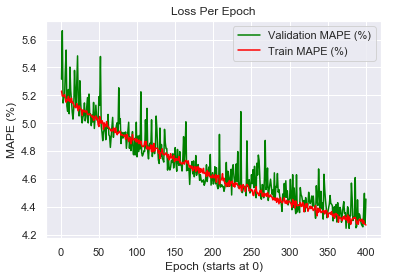

In [132]:
plt.plot(1+np.arange(start, stop), history_df['val_loss'][start:], c='green')
plt.plot(1+np.arange(start, stop), history_df['loss'][start:], c='red')
plt.legend(('Validation MAPE (%)', 'Train MAPE (%)'))
plt.title('Loss Per Epoch')
plt.xlabel('Epoch (starts at {})'.format(start))
plt.ylabel('MAPE (%)')

Text(0, 0.5, 'MAE')

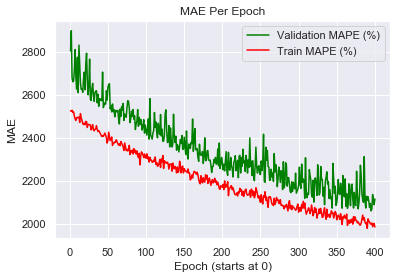

In [133]:
plt.plot(1+np.arange(start, stop), history_df['val_mae'][start:], 'green')
plt.plot(1+np.arange(start, stop), history_df['mae'][start:], c='red')
plt.legend(('Validation MAPE (%)', 'Train MAPE (%)'))
plt.title('MAE Per Epoch')
plt.xlabel('Epoch (starts at {})'.format(start))
plt.ylabel('MAE')

#### Plotting actual vs predicted `MSRP` (not actual test data)

In [134]:
pred = model.predict(x)

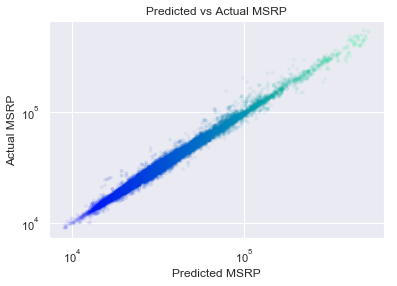

In [137]:
plt.scatter(pred, y, alpha=0.05, c=np.log(pred), cmap='winter', s=8) # winter, summer
plt.xlabel('Predicted MSRP')
plt.ylabel('Actual MSRP')
plt.title('Predicted vs Actual MSRP')
xticks = plt.xticks(ticks, labels)
yticks = plt.yticks(ticks, labels)
plt.yscale('log')
plt.xscale('log')
# plt.savefig('C:/Users/Nicolas/Documents/Scraping/thecarconnection/pred_msrp.jpg')

In [138]:
np.corrcoef(model.predict(x).ravel(), y)

array([[1.        , 0.99222246],
       [0.99222246, 1.        ]])

# Comparing performance with Linear Regression

In [139]:
lin_reg = LinearRegression()

In [140]:
x = dataset.loc[:, ['Drivetrain', 'Passenger Capacity', 'Passenger Doors', 'Body Style',
       'EPA Classification', 'Front Shoulder Room (in)',
       'Front Head Room (in)', 'Second Leg Room (in)', 'Front Leg Room (in)',
       'Second Shoulder Room (in)', 'Second Head Room (in)',
       'Height, Overall (in)', 'Wheelbase (in)', 'Width, Max w/o mirrors (in)',
       'Fuel Tank Capacity, Approx (gal)', 'EPA Fuel Economy Est - Hwy (MPG)',
       'EPA Fuel Economy Est - City (MPG)', 'Fuel System',
       'Third Gear Ratio (:1)', 'First Gear Ratio (:1)',
       'Fourth Gear Ratio (:1)', 'Second Gear Ratio (:1)',
       'Front Brake Rotor Diam x Thickness (in)',
       'Rear Brake Rotor Diam x Thickness (in)', 'Steering Type',
       'Turning Diameter - Curb to Curb', 'Rear Wheel Material',
       'Suspension Type - Front', 'Air Bag-Frontal-Driver',
       'Air Bag-Frontal-Passenger', 'Air Bag-Passenger Switch (On/Off)',
       'Air Bag-Side Body-Front', 'Air Bag-Side Body-Rear',
       'Air Bag-Side Head-Front', 'Air Bag-Side Head-Rear', 'Brakes-ABS',
       'Child Safety Rear Door Locks', 'Daytime Running Lights',
       'Traction Control', 'Night Vision', 'Rollover Protection Bars',
       'Fog Lamps', 'Parking Aid', 'Tire Pressure Monitor', 'Back-Up Camera',
       'Stability Control', 'Other Features', 'Basic Miles/km', 'Basic Years',
       'Corrosion Miles/km', 'Corrosion Years', 'Drivetrain Miles/km',
       'Drivetrain Years', 'Roadside Assistance Miles/km',
       'Roadside Assistance Years', 'Hybrid Engine', 'Gears', 'Net Horsepower',
       'Net Horsepower RPM', 'Net Torque', 'Net Torque RPM', 'Cylinders',
       'Engine Configuration', 'Displacement (L)', 'Displacement (cc)',
       'Rear Tire Width', 'Front Tire Width', 'Rear Wheel Size',
       'Front Wheel Size', 'Tire Rating', 'Tire Width Ratio',
       'Wheel Size Ratio', 'Tire Ratio', 'Year', 'Country',
       'Category', 'Make']] # make was added
y = dataset['MSRP']

In [141]:
specs_to_dummies = ['Drivetrain', 'Fuel System', 'Steering Type', 'Rear Wheel Material',
                   'Suspension Type - Front', 'Engine Configuration', 'Tire Rating', 'Country',
                   'Category', 'Make']

for item in specs_to_dummies:
    dummies = pd.get_dummies(x[item], prefix_sep=': ', prefix=item)
    x = x.drop(item, axis=1)
    x = pd.concat([x, dummies], sort=False, axis=1)
x = x.reset_index(drop=True)

specs_to_one_two = ['Air Bag-Frontal-Driver', 'Air Bag-Frontal-Passenger', 'Air Bag-Passenger Switch (On/Off)',
       'Air Bag-Side Body-Front', 'Air Bag-Side Body-Rear', 'Air Bag-Side Head-Front', 'Air Bag-Side Head-Rear', 
       'Brakes-ABS', 'Child Safety Rear Door Locks', 'Daytime Running Lights',
       'Traction Control', 'Night Vision', 'Rollover Protection Bars',
       'Fog Lamps', 'Parking Aid', 'Tire Pressure Monitor', 'Back-Up Camera',
       'Stability Control']

for item in specs_to_one_two:
    dummies = pd.get_dummies(x[item], prefix_sep=': ', prefix=item, drop_first=True)
    x = x.drop(item, axis=1)
    x = pd.concat([x, dummies], sort=False, axis=1)
x = x.reset_index(drop=True)

x.drop(['Body Style', 'EPA Classification', 'Other Features'], axis=1, inplace=True)

In [142]:
x = StandardScaler().fit_transform(x.astype(np.float64))

In [143]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2)

In [144]:
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
mean_absolute_error(y_test, y_pred)

5248.367074221975

Neural network wins again.

# Comparing performance with Ridge Regression

In [145]:
ridge = Ridge()

In [146]:
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
mean_absolute_error(y_test, y_pred)

5248.658302008889